### Большая просьба, проверить работу 05.08.2020. Сейчас работа в процессе выполнения, конечный вариант выложу позже.

--------------------------------------------------------------------------------

## Домашняя работа №6.

Обучить сиамскую сеть для верификации лиц на датасете LFW.
Библиотеки: [Python, Tensorflow].

### Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

import imageio
from skimage.transform import resize

### Загрузка и подготовка датасета LFW

In [3]:
if 1:
  (train_ds, test_ds), info_ds = tfds.load(
      'lfw',
      as_supervised=True,
      with_info=True,
      split=['train[:90%]', 'train[90%:]']
  )

In [4]:
info_ds

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

### Визуализация датасета LFW

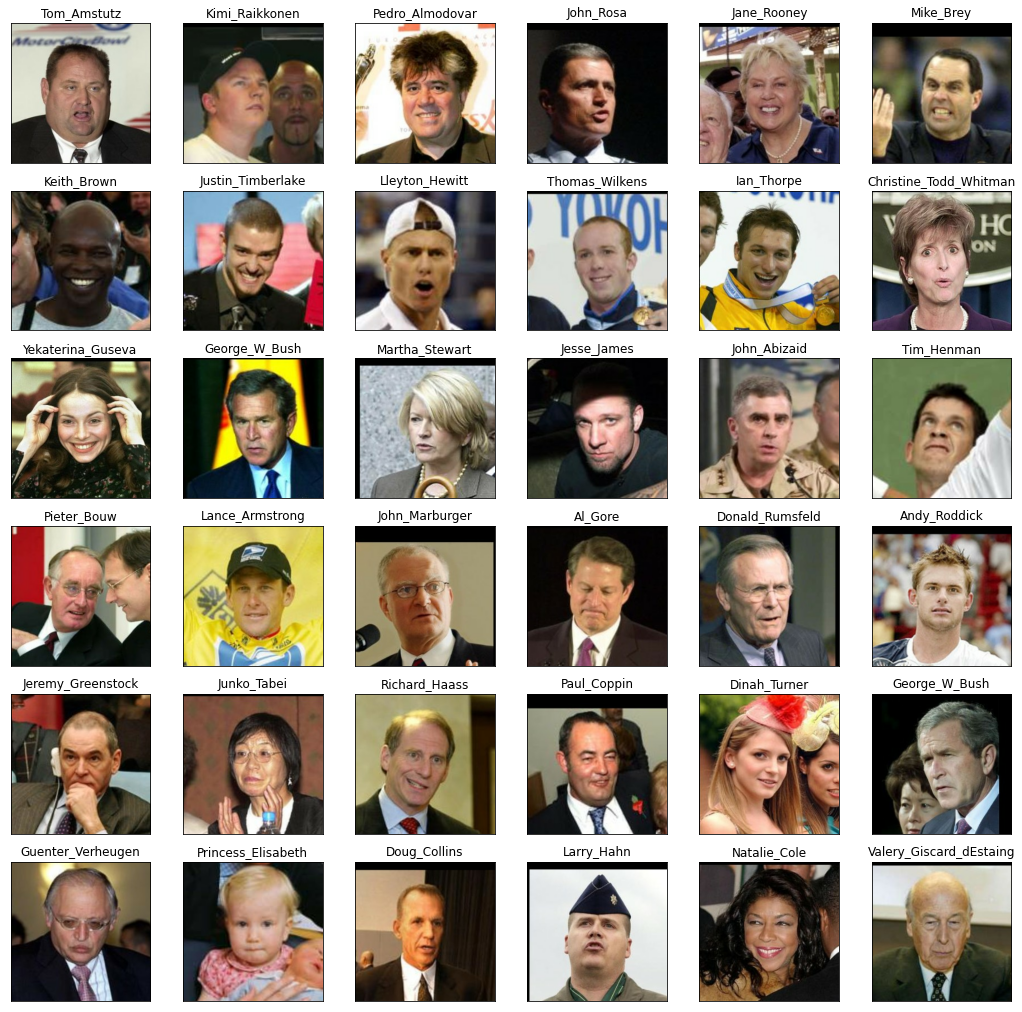

In [5]:
samples = [[x[0], x[1]] for x in iter(train_ds.take(36))]

fig = plt.figure(figsize=(18,18))

for i in range(len(samples)):
  ax = fig.add_subplot(6,6, i+1)
  ax.set_title(samples[i][0].numpy().decode('UTF-8'))
  ax.imshow(samples[i][1])
  plt.xticks([]), plt.yticks([])

plt.show()

### Создание модели CNN

In [6]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

### Contrastive Loss

In [7]:
MARGIN = 10.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

### Подготовка пайплайна данных

In [8]:
def normal(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [9]:
BATCH_SIZE = 64
NUM_EPOCHS = 4

train_ds = train_ds.map(normal)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

### Подготовка к обучению

In [10]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

### Обучение модели

In [12]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 100 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 0.6573429703712463
[100] Loss: 12.502333641052246
[200] Loss: 1.2232635021209717
[300] Loss: 0.0
[400] Loss: 0.051022861152887344
[500] Loss: 0.0
[600] Loss: 0.02872445620596409
[700] Loss: 0.0
CPU times: user 3min 12s, sys: 1min 37s, total: 4min 50s
Wall time: 6min 3s
